<a href="https://colab.research.google.com/github/erosas-utec/IAfundamentals/blob/main/Forecasting_de_Ventas_en_Retail_Caso_Walmart_Erick_Rosas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting de Ventas en el Sector Retail: Caso Walmart**
> Por: Erick Rosas Pisfil

 Flujo general:
 1.  Instalación / imports
 2.  Carga y exploración
 3.  Limpieza + Feature Engineering
 4.  Split temporal 70-15-15
 5.  Random Forest con GridSearch
 6.  LSTM (Keras + GPU)
 7.  Modelo híbrido LSTM → RF
 8.  Métricas finales y feature importance

In [16]:
import pandas as pd
import numpy as np
import holidays
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tqdm.auto import tqdm
import matplotlib.pyplot as plt



In [2]:
# Carga y exploración

DATA_PATH = 'https://raw.githubusercontent.com/erosas-utec/IAfundamentals/main/Walmart_Dataset.csv'
df = pd.read_csv(DATA_PATH)


df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

print("Columnas:", list(df.columns))
df.head()

Columnas: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
# Limpieza y Feature Engineering

# Variables temporales
df['Year']    = df['Date'].dt.year
df['Month']   = df['Date'].dt.month
df['Week']    = df['Date'].dt.isocalendar().week.astype(int)
df['Quarter'] = df['Date'].dt.quarter

# Festivos de EE. UU.
us_holidays = holidays.US()
df['Is_US_Holiday'] = df['Date'].isin(us_holidays).astype(int)

# Lags y medias móviles por tienda
for lag in [1, 2, 4]:
    df[f'Lag_{lag}'] = df.groupby('Store')['Weekly_Sales'].shift(lag)

df['Rolling_4']  = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(4).mean()
df['Rolling_12'] = df.groupby('Store')['Weekly_Sales'].shift(1).rolling(12).mean()

# Drop de filas con NaN generadas por los lags/rolling
df = df.dropna().reset_index(drop=True)


In [4]:
# Split temporal train / valid / test (70-15-15)

total_weeks = df['Date'].nunique()
train_weeks = int(total_weeks * 0.70)
valid_weeks = int(total_weeks * 0.15)

dates_sorted = df['Date'].sort_values().unique()
train_cutoff = dates_sorted[train_weeks - 1]
valid_cutoff = dates_sorted[train_weeks + valid_weeks - 1]

train_df = df[df['Date'] <= train_cutoff].copy()
valid_df = df[(df['Date'] > train_cutoff) & (df['Date'] <= valid_cutoff)].copy()
test_df  = df[df['Date'] > valid_cutoff].copy()

FEATURES = ['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'Holiday_Flag', 'Is_US_Holiday',
            'Year', 'Month', 'Week', 'Quarter',
            'Lag_1', 'Lag_2', 'Lag_4', 'Rolling_4', 'Rolling_12']
TARGET = 'Weekly_Sales'

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_valid, y_valid = valid_df[FEATURES], valid_df[TARGET]
X_test,  y_test  = test_df[FEATURES],  test_df[TARGET]


In [5]:
# Random Forest

rf_params = {
    'n_estimators':      [400, 500, 600],
    'max_depth':         [None, 10, 15],
    'min_samples_leaf':  [1, 2, 4]
}
tscv = TimeSeriesSplit(n_splits=3)
rf_base = RandomForestRegressor(n_jobs=-1, random_state=42)

grid_rf = GridSearchCV(
    rf_base, rf_params,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print(f"Mejor RF params: {grid_rf.best_params_}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=   6.0s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=   9.8s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=  13.1s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=   5.7s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=  10.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=  16.0s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=   7.2s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=  12.7s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=  19.0s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=400; total time=   5.5s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=400; total time=   6.5s
[CV] END max_depth=None, min_samples_

In [6]:
# LSTM

LOOK_BACK = 4
SCALER = MinMaxScaler()

def create_sequences(df_part, features, target, look_back=LOOK_BACK):
    X_seq, y_seq = [], []
    for _, grp in df_part.groupby('Store'):
        feat = grp[features].values.astype(np.float32)
        targ = grp[target].values.astype(np.float32)
        feat_scaled = SCALER.fit_transform(feat)
        for i in range(look_back, len(feat_scaled)):
            X_seq.append(feat_scaled[i - look_back:i])
            y_seq.append(targ[i])
    return np.array(X_seq), np.array(y_seq)

X_train_lstm, y_train_lstm = create_sequences(train_df, FEATURES, TARGET)
X_valid_lstm, y_valid_lstm = create_sequences(valid_df, FEATURES, TARGET)
X_test_lstm,  y_test_lstm  = create_sequences(test_df,  FEATURES, TARGET)

# Arquitectura LSTM
def make_lstm_model():
    model = models.Sequential([
        layers.Input(shape=(LOOK_BACK, len(FEATURES))),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(1e-3),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

model = make_lstm_model()
early = callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                patience=5, restore_best_weights=True)

history = model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_valid_lstm, y_valid_lstm),
    epochs=50, batch_size=256,
    callbacks=[early], verbose=2)


Epoch 1/50
16/16 - 7s - 424ms/step - loss: 1443887448064.0000 - root_mean_squared_error: 1201618.6250 - val_loss: 1382277316608.0000 - val_root_mean_squared_error: 1175702.8750
Epoch 2/50
16/16 - 0s - 29ms/step - loss: 1443884826624.0000 - root_mean_squared_error: 1201617.6250 - val_loss: 1382271942656.0000 - val_root_mean_squared_error: 1175700.6250
Epoch 3/50
16/16 - 0s - 24ms/step - loss: 1443878404096.0000 - root_mean_squared_error: 1201614.8750 - val_loss: 1382265520128.0000 - val_root_mean_squared_error: 1175697.8750
Epoch 4/50
16/16 - 1s - 46ms/step - loss: 1443872636928.0000 - root_mean_squared_error: 1201612.5000 - val_loss: 1382260801536.0000 - val_root_mean_squared_error: 1175695.8750
Epoch 5/50
16/16 - 0s - 24ms/step - loss: 1443868049408.0000 - root_mean_squared_error: 1201610.6250 - val_loss: 1382256476160.0000 - val_root_mean_squared_error: 1175694.0000
Epoch 6/50
16/16 - 1s - 38ms/step - loss: 1443863724032.0000 - root_mean_squared_error: 1201608.7500 - val_loss: 138225

In [7]:
# Crear feature LSTM_pred y entrenar modelo híbrido

def add_lstm_pred(df_source):
    preds = []
    idx_map = []
    for store, grp in df_source.groupby('Store'):
        feat = grp[FEATURES].values.astype(np.float32)
        feat_scaled = SCALER.fit_transform(feat)
        # Crear ventanas
        store_X = []
        for i in range(LOOK_BACK, len(feat_scaled)):
            store_X.append(feat_scaled[i-LOOK_BACK:i])
        # Predicciones
        store_pred = model.predict(np.array(store_X), verbose=0).flatten()
        # Padding delante para alinear
        store_pred = [np.nan]*LOOK_BACK + store_pred.tolist()
        preds.extend(store_pred)
        idx_map.extend(grp.index.tolist())
    df_source['lstm_pred'] = pd.Series(preds, index=idx_map)
    return df_source.dropna(subset=['lstm_pred'])

train_h = add_lstm_pred(train_df.copy())
valid_h = add_lstm_pred(valid_df.copy())
test_h  = add_lstm_pred(test_df.copy())

FEATURES_H = FEATURES + ['lstm_pred']

X_train_h, y_train_h = train_h[FEATURES_H], train_h[TARGET]
X_valid_h, y_valid_h = valid_h[FEATURES_H], valid_h[TARGET]
X_test_h,  y_test_h  = test_h[FEATURES_H],  test_h[TARGET]

rf_hybrid = RandomForestRegressor(
    n_estimators=grid_rf.best_params_['n_estimators'],
    max_depth=grid_rf.best_params_['max_depth'],
    min_samples_leaf=grid_rf.best_params_['min_samples_leaf'],
    n_jobs=-1,
    random_state=42
).fit(X_train_h, y_train_h)


In [8]:
# Métricas finales

def evaluate(name, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)   # siempre existe
    rmse = np.sqrt(mse)                         # raíz para obtener RMSE
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    return {'Model': name, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

results = []
results.append(evaluate('RF', y_test, best_rf.predict(X_test)))
results.append(evaluate('LSTM', y_test_lstm, model.predict(X_test_lstm).flatten()))
results.append(evaluate('Híbrido', y_test_h, rf_hybrid.predict(X_test_h)))

print("\n====== Resultados en TEST ======")
for r in results:
    print(f"{r['Model']}: RMSE={r['RMSE']:.0f} | MAE={r['MAE']:.0f} | MAPE={r['MAPE']:.2f}%")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

====== Resultados en TEST ======
RF: RMSE=62832 | MAE=43413 | MAPE=4.26%
LSTM: RMSE=1159387 | MAE=1031563 | MAPE=99.96%
Híbrido: RMSE=64490 | MAE=44616 | MAPE=4.39%


In [9]:
# Importancia de variables (RF baseline)
importances = pd.Series(best_rf.feature_importances_, index=FEATURES)
print("\nTop 10 features RF:")
print(importances.sort_values(ascending=False).head(10))


Top 10 features RF:
Rolling_4       0.450606
Lag_1           0.371859
Rolling_12      0.086873
Week            0.039217
Lag_4           0.032695
Lag_2           0.007666
Holiday_Flag    0.002099
Temperature     0.001703
CPI             0.001614
Unemployment    0.001553
dtype: float64


**EXPERIMENTOS**

In [10]:
# EXPERIMENTO N° 1:  E1 – Baseline (RF y LSTM simples)
# RANDOM FOREST BASELINE (parámetros por defecto)

from sklearn.ensemble import RandomForestRegressor
rf_base = RandomForestRegressor(
    n_estimators=100,      # default
    random_state=42,
    n_jobs=-1
).fit(X_train, y_train)

# LSTM BASELINE (arquitectura liviana)
model_base = tf.keras.Sequential([
    layers.Input(shape=(LOOK_BACK, len(FEATURES))),
    layers.LSTM(32),
    layers.Dense(1)
])
model_base.compile(
    loss='mse',
    optimizer='adam',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model_base.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_valid_lstm, y_valid_lstm),
    epochs=30, batch_size=128,
    verbose=2
)


Epoch 1/30
31/31 - 3s - 92ms/step - loss: 1443887054848.0000 - root_mean_squared_error: 1201618.5000 - val_loss: 1382275612672.0000 - val_root_mean_squared_error: 1175702.1250
Epoch 2/30
31/31 - 0s - 13ms/step - loss: 1443881287680.0000 - root_mean_squared_error: 1201616.1250 - val_loss: 1382266830848.0000 - val_root_mean_squared_error: 1175698.5000
Epoch 3/30
31/31 - 0s - 7ms/step - loss: 1443872243712.0000 - root_mean_squared_error: 1201612.3750 - val_loss: 1382259621888.0000 - val_root_mean_squared_error: 1175695.3750
Epoch 4/30
31/31 - 0s - 10ms/step - loss: 1443866738688.0000 - root_mean_squared_error: 1201610.0000 - val_loss: 1382255689728.0000 - val_root_mean_squared_error: 1175693.7500
Epoch 5/30
31/31 - 0s - 14ms/step - loss: 1443863330816.0000 - root_mean_squared_error: 1201608.6250 - val_loss: 1382252544000.0000 - val_root_mean_squared_error: 1175692.3750
Epoch 6/30
31/31 - 0s - 16ms/step - loss: 1443860185088.0000 - root_mean_squared_error: 1201607.3750 - val_loss: 13822497

In [17]:
# EXPERIMENTO N° 2:  E2 – Hyper-tuning (RF_grid + LSTM_tuned)

rf_params = {
    'n_estimators': [400, 500, 600],
    'max_depth':   [None, 10, 15],
    'min_samples_leaf': [1, 2, 4]
}
tscv = TimeSeriesSplit(n_splits=3)
rf_tuned = GridSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    rf_params, cv=tscv,
    scoring='neg_root_mean_squared_error',
    verbose=2
).fit(X_train, y_train).best_estimator_

# LSTM TUNEADA (más unidades + dropout)
def make_lstm_tuned():
    m = tf.keras.Sequential([
        layers.Input(shape=(LOOK_BACK, len(FEATURES))),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    m.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return m

model_tuned = make_lstm_tuned()
early = callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5, restore_best_weights=True)
model_tuned.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_valid_lstm, y_valid_lstm),
    epochs=50, batch_size=256,
    callbacks=[early], verbose=2)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=   4.8s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=  10.4s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=400; total time=  13.6s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=   5.1s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=  12.7s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=500; total time=  17.8s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=   7.4s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=  14.9s
[CV] END max_depth=None, min_samples_leaf=1, n_estimators=600; total time=  21.4s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=400; total time=   3.4s
[CV] END max_depth=None, min_samples_leaf=2, n_estimators=400; total time=   7.6s
[CV] END max_depth=None, min_samples_

In [18]:
# EXPERIMENTO N° 3:  E3 – Ablation (sin variables externas)
# Definir FEATURES sin macro-variables

EXOG = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
FEATURES_NOEXOG = [c for c in FEATURES if c not in EXOG]

# Construir matrices
X_train_nx = train_df[FEATURES_NOEXOG]
X_valid_nx = valid_df[FEATURES_NOEXOG]
X_test_nx  = test_df[FEATURES_NOEXOG]

# RANDOM FOREST sin exógenas
rf_noexog = RandomForestRegressor(
    n_estimators=rf_tuned.n_estimators,
    max_depth=rf_tuned.max_depth,
    min_samples_leaf=rf_tuned.min_samples_leaf,
    n_jobs=-1, random_state=42
).fit(X_train_nx, y_train)

# LSTM sin exógenas
X_train_lstm_nx, y_train_lstm = create_sequences(train_df, FEATURES_NOEXOG, TARGET)
X_valid_lstm_nx, y_valid_lstm = create_sequences(valid_df, FEATURES_NOEXOG, TARGET)
X_test_lstm_nx,  y_test_lstm  = create_sequences(test_df,  FEATURES_NOEXOG, TARGET)

lstm_noexog = tf.keras.Sequential([
    layers.Input(shape=(LOOK_BACK, len(FEATURES_NOEXOG))),
    layers.LSTM(64), layers.Dense(1)
])
lstm_noexog.compile(loss='mse', optimizer='adam',
                    metrics=[tf.keras.metrics.RootMeanSquaredError()])
lstm_noexog.fit(
    X_train_lstm_nx, y_train_lstm,
    validation_data=(X_valid_lstm_nx, y_valid_lstm),
    epochs=40, batch_size=128, verbose=2)


Epoch 1/40
31/31 - 5s - 171ms/step - loss: 1443886399488.0000 - root_mean_squared_error: 1201618.2500 - val_loss: 1382272729088.0000 - val_root_mean_squared_error: 1175701.0000
Epoch 2/40
31/31 - 0s - 11ms/step - loss: 1443874209792.0000 - root_mean_squared_error: 1201613.1250 - val_loss: 1382254379008.0000 - val_root_mean_squared_error: 1175693.1250
Epoch 3/40
31/31 - 1s - 20ms/step - loss: 1443859267584.0000 - root_mean_squared_error: 1201607.0000 - val_loss: 1382245859328.0000 - val_root_mean_squared_error: 1175689.5000
Epoch 4/40
31/31 - 1s - 28ms/step - loss: 1443852320768.0000 - root_mean_squared_error: 1201604.0000 - val_loss: 1382240092160.0000 - val_root_mean_squared_error: 1175687.1250
Epoch 5/40
31/31 - 1s - 19ms/step - loss: 1443846684672.0000 - root_mean_squared_error: 1201601.7500 - val_loss: 1382234849280.0000 - val_root_mean_squared_error: 1175684.8750
Epoch 6/40
31/31 - 0s - 13ms/step - loss: 1443841572864.0000 - root_mean_squared_error: 1201599.6250 - val_loss: 138222

In [19]:
# EXPERIMENTO N° 4:  E4 – Modelo híbrido (LSTM_pred → RF)
# Obtener predicciones de la LSTM_tuned en cada set

def add_lstm_pred(df_src, feats):
    preds, idx = [], []
    for store, g in df_src.groupby('Store'):
        X_seq, _ = create_sequences(g, feats, TARGET)
        pred = model_tuned.predict(X_seq, verbose=0).flatten()
        # padding
        pred = [np.nan]*LOOK_BACK + pred.tolist()
        preds.extend(pred)
        idx.extend(g.index)
    df_src = df_src.copy()
    df_src['lstm_pred'] = pd.Series(preds, index=idx)
    return df_src.dropna(subset=['lstm_pred'])

train_h = add_lstm_pred(train_df, FEATURES)
valid_h = add_lstm_pred(valid_df, FEATURES)
test_h  = add_lstm_pred(test_df,  FEATURES)

FEATURES_H = FEATURES + ['lstm_pred']
X_train_h, y_train_h = train_h[FEATURES_H], train_h[TARGET]
X_test_h,  y_test_h  = test_h[FEATURES_H],  test_h[TARGET]

# RF sobre las features + lstm_pred
rf_hybrid = RandomForestRegressor(
    n_estimators=rf_tuned.n_estimators,
    max_depth=rf_tuned.max_depth,
    min_samples_leaf=rf_tuned.min_samples_leaf,
    n_jobs=-1, random_state=42
).fit(X_train_h, y_train_h)


**RESULTADOS**

In [20]:

# función utilitaria
def log_result(lst, exp_id, model_name, y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    lst.append({
        'Experimento': exp_id,
        'Modelo': model_name,
        'RMSE':  np.sqrt(mse),
        'MAE':   mean_absolute_error(y_true, y_pred),
        'MAPE':  mean_absolute_percentage_error(y_true, y_pred)*100
    })



# registrar resultados
records = []
log_result(records, 'E1', 'RF_base',    y_test,      rf_base.predict(X_test))
log_result(records, 'E1', 'LSTM_base',  y_test_lstm, model_base.predict(X_test_lstm).flatten())

log_result(records, 'E2', 'RF_tuned',   y_test,      rf_tuned.predict(X_test))
log_result(records, 'E2', 'LSTM_tuned', y_test_lstm, model_tuned.predict(X_test_lstm).flatten())

log_result(records, 'E3', 'RF_noExog',   y_test,      rf_noexog.predict(X_test_nx))
log_result(records, 'E3', 'LSTM_noExog', y_test_lstm, lstm_noexog.predict(X_test_lstm_nx).flatten())

log_result(records, 'E4', 'Hybrid', y_test_h, rf_hybrid.predict(X_test_h))

# tabla comparativa
df_res = pd.DataFrame(records)
display(df_res)



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


,Experimento,Modelo,RMSE,MAE,MAPE
0,E1,RF_base,6.444441e+04,4.589701e+04,4.853498
1,E1,LSTM_base,1.159610e+06,1.031813e+06,99.994636
2,E2,RF_tuned,6.283173e+04,4.341309e+04,4.260605
3,E2,LSTM_tuned,1.159320e+06,1.031487e+06,99.951190
4,E3,RF_noExog,6.221702e+04,4.234517e+04,4.031661
5,E3,LSTM_noExog,1.159561e+06,1.031758e+06,99.987346
6,E4,Hybrid,6.440354e+04,4.453111e+04,4.375725


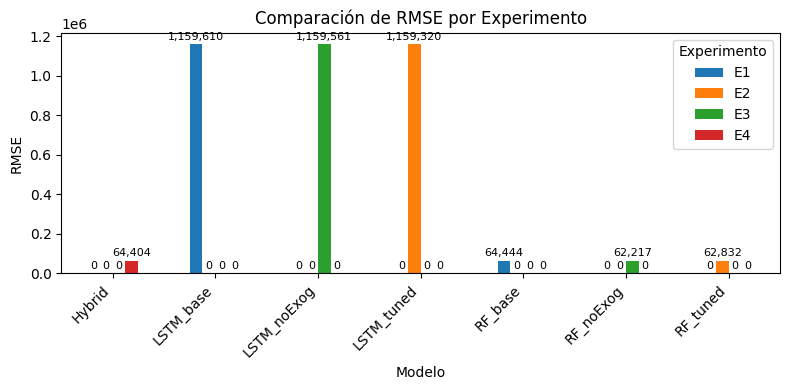

In [22]:
# gráfico de barras

pivot_rmse = df_res.pivot(index='Modelo', columns='Experimento', values='RMSE')

fig, ax = plt.subplots(figsize=(8, 4))
pivot_rmse.plot(kind='bar', ax=ax)

ax.set_title('Comparación de RMSE por Experimento')
ax.set_ylabel('RMSE')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# añadir etiquetas numéricas ---
for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f'{v:,.0f}' for v in container.datavalues],
        label_type='edge',
        padding=2,
        fontsize=8
    )

plt.tight_layout()
plt.show()
